In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
import pickle
import sys
import yaml

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, TimeDistributed, Bidirectional
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.utils import plot_model
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import load_model
from sklearn import preprocessing
from copy import deepcopy

import datetime
import math
import hashlib
import time
import os
from datagenerator import DataGenerator

# add
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

Using TensorFlow backend.


In [2]:
#Disable randomization
import random
seed_value=2020 #10 #
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
random.seed(seed_value)

# add
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True 
# # sess = tf.Session(config=config) 
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [3]:
def loadConfig():
#     with open('/home/wesleyjtann/ddos_research/test/light_config_b.yaml', "r") as ymlfile:
    with open('./light_config.yaml', "r") as ymlfile: #GE, hulk, slowhttp, slowloris, heartbleed
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()
# artefact = 'artefact' #'artefact_b' #

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


## Helper functions

In [4]:
def prepare_sentence(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqY = np.append(seq, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    y= pad_sequences([seqY],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    return [x], [y]


def getTokenizer(df) :
    ### Dictionary for Normal ###
    tokenizer = Tokenizer(filters='', split='<sep>', oov_token='<OTHERS>' ,lower=True)
    tokenizer.fit_on_texts(df['Input'].values)

    tokenizer.fit_on_texts(['<SOS>'])
    tokenizer.fit_on_texts(['<EOS>'])

    return tokenizer

# def createGeneratorData(df, tokenizer, max_len) :
#     #Prepare training for normal model
#     x = []
#     y = []

#     for seq in df['Input']:
#         x_windows, y_windows = prepare_sentence(seq, max_len, tokenizer)
#         x += x_windows
#         y += y_windows
#     x = np.array(x)
#     y = np.array(y)  # The word <PAD> does not constitute a class

#     x.shape = [len(x), max_len + 1, 1]
#     y.shape = [len(y), max_len + 1, 1]

#     return x, y

def prepare_sentence_classification(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
#     seqX = np.append(seq, tokenizer.word_index['<eos>'])
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqX = np.append(seqX, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+2,
        padding='post')[0]  # Pads before each sequence

    return [x]


def create_input_data(df, tokenizer, max_len):
    #Prepare training for normal model
    x=[]; y=[]
    for index, row in df.iterrows():
        x_windows = prepare_sentence_classification(row['Input'], max_len, tokenizer)
#         y_labels = row['Label']
        y_labels = row['Attack']
#         x += x_windows
        x.append(x_windows)
        y.append(y_labels)
        
    x = np.array(x)
    y = np.array(y)
#     x.shape = [len(x), max_len+2, 1]
    x = np.reshape(x, (len(x), (max_len+2)))#, 1))

    return x, y

## Loading CIC Friday dataset

##### Training set

In [5]:
# N1 data
df_normal = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'N1.csv')
print("size of normal data: ", len(df_normal))
# df_normal.head()

size of normal data:  10054


In [6]:
# Entire train atk set. 
df_attackfull = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_full.csv')
print("size of full attack data: ", len(df_attackfull))

size of full attack data:  8311


In [7]:
# make attack 80% of train data 
ratio = 0.5 #0.8 #0.2
df_attacksmall = df_attackfull[-int(len(df_normal)/ratio - len(df_normal)):]
print("size of smaller attack data: ", len(df_attacksmall))

size of smaller attack data:  8311


In [8]:
# add AGT labels for evaluation
df_normal['Attack'] = 0
# df_attacksmall['Attack'] = 1

attacker='172.16.0.1'; victim='192.168.10.50'
df_attacksmall['Attack'] = 0
# if IP == attacker or IP == victim
df_attacksmall.loc[df_attacksmall['Source IP']==attacker, 'Attack'] = 1
df_attacksmall.loc[df_attacksmall['Source IP']==victim, 'Attack'] = 1
# print("df_attacksmall value counts: \n", (df_attacksmall['Attack']).value_counts())

# Join and shuffle train attack and normal data
df_train = df_normal.append(df_attacksmall).sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
# df_train =df_normal # df_attacksmall #
print("size of df_train: ", len(df_train))
print("df_train value counts: \n", (df_train['Attack']).value_counts())

size of df_train:  18365
df_train value counts: 
 0    14256
1     4109
Name: Attack, dtype: int64


/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
numtrain_atk = df_train['Attack'].values.sum()  # True
numtrain_atk

numtrain_norm = len(df_train) - df_train['Attack'].sum()  
numtrain_norm

# count atk percentage in test set
# num_norm, num_atk = (df_test['Attack']).value_counts()

print("Length of test data: ", len(df_train))
print("Number of normal traffic: ", numtrain_norm)
print("Number of true attacks: ", numtrain_atk)
print("Percent attacks: ", numtrain_atk / len(df_train))

Length of test data:  18365
Number of normal traffic:  14256
Number of true attacks:  4109
Percent attacks:  0.22374081132589163


##### Test set

In [10]:
# Load test set
df_test = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'TEST.csv')
print("size of df_test: ", len(df_test))

size of df_test:  2447


In [11]:
# Add labels to test set
attacker='172.16.0.1'; victim='192.168.10.50'
df_test['Attack'] = 0

# if IP == attacker or IP == victim
df_test.loc[df_test['Source IP']==attacker, 'Attack'] = 1
df_test.loc[df_test['Source IP']==victim, 'Attack'] = 1

df_test = df_test.sample(frac=1, random_state=39, replace=False)

In [12]:
(df_test['Attack']).value_counts()

1    1378
0    1069
Name: Attack, dtype: int64

In [13]:
num_atk = df_test['Attack'].values.sum()  # True
num_atk

1378

In [14]:
num_norm = len(df_test) - df_test['Attack'].sum()  
num_norm

1069

In [15]:
# count atk percentage in test set
# num_norm, num_atk = (df_test['Attack']).value_counts()

print("Length of test data: ", len(df_test))
print("Number of normal traffic: ", num_norm)
print("Number of true attacks: ", num_atk)
print("Percent attacks: ", num_atk / len(df_test))

Length of test data:  2447
Number of normal traffic:  1069
Number of true attacks:  1378
Percent attacks:  0.5631385369840621


### Prepare data

In [16]:
max_len = config['SEQUENCELENGTH']

tokenizer = getTokenizer(df_train)  

In [17]:
def prep_modelinputs(df, max_len, tokenizer):
    df_embedded = df.copy()
    df_embedded['Input'] = tokenizer.texts_to_sequences(df['Input'].values)
    # Shuffle the data order
    df_embedded_shuf = df_embedded.sample(frac=1, random_state=42, replace=False)
    # Extract inputs and labels
    X_tmp, y_tmp = create_input_data(df_embedded_shuf, tokenizer, max_len)
    # Convert format for training  
    y_tmp = to_categorical(y_tmp, num_classes=2)
    return X_tmp, y_tmp

In [18]:
X_norm, y_norm = prep_modelinputs(df_normal, max_len, tokenizer)
print(X_norm.shape, y_norm.shape)

(10054, 202) (10054, 2)


In [19]:
X_train, y_train = prep_modelinputs(df_train, max_len, tokenizer)
print(X_train.shape, y_train.shape)

(18365, 202) (18365, 2)


In [20]:
X_test, y_test = prep_modelinputs(df_test, max_len, tokenizer)
print(X_test.shape, y_test.shape)

(2447, 202) (2447, 2)


In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

print("Training set, counts of label '0': {}".format(int(np.sum(y_train, axis=0)[0])))
print("Training set, counts of label '1': {}".format(int(np.sum(y_train, axis=0)[1])))
print("Test set, counts of label '0': {}".format(int(np.sum(y_test, axis=0)[0])))
print("Test set, counts of label '1': {}".format(int(np.sum(y_test, axis=0)[1])))

Number transactions X_train dataset:  (18365, 202)
Number transactions y_train dataset:  (18365, 2)
Number transactions X_test dataset:  (2447, 202)
Number transactions y_test dataset:  (2447, 2)
Training set, counts of label '0': 14256
Training set, counts of label '1': 4109
Test set, counts of label '0': 1069
Test set, counts of label '1': 1378


### Model

In [22]:
vocab_size=[len(tokenizer.word_index)] 
input_emb_dim = config['MODELPARAMS']['INPUT_EMBED_DIM'] #512
lstm_emb_dim = config['MODELPARAMS']['LSTM_DIM'] #300
print("vocab_size: ", vocab_size)

vocab_size:  [757]


In [23]:
model = Sequential()
model.add(Embedding(vocab_size[0] + 1, input_emb_dim, input_length=X_train.shape[1]))
model.add(LSTM(lstm_emb_dim, return_sequences=True)) # dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(lstm_emb_dim))
# model.add(TimeDistributed(Dense(2, activation='sigmoid')))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer=optimizers.adam(lr=0.005), 
              loss='binary_crossentropy', metrics=['acc']) #lr=0.005 config['MODELPARAMS']['LEARNING_RATE_P']

print(model.summary())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 202, 512)          388096    
_________________________________________________________________
lstm_1 (LSTM)                (None, 202, 300)          975600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 602       
Total params: 2,085,498
Trainable params: 2,085,498
Non-trainable params: 0
_________________________________________________________________
None


## Full classifier training

In [24]:
history = model.fit(X_train, y_train, epochs=config['TRAININGPARAMS']['EPOCHS_P'], 
                      batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], validation_split=0.2, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=7, 
                                               mode='auto', min_delta=0.0002)]) #


Train on 14692 samples, validate on 3673 samples
Epoch 1/30
14692/14692 [==============================] - 52s 4ms/step - loss: 0.0868 - acc: 0.9672 - val_loss: 0.0356 - val_acc: 0.9943
Epoch 2/30
14692/14692 [==============================] - 37s 3ms/step - loss: 0.0404 - acc: 0.9919 - val_loss: 0.0311 - val_acc: 0.9944
Epoch 3/30
14692/14692 [==============================] - 37s 3ms/step - loss: 0.0270 - acc: 0.9946 - val_loss: 0.0291 - val_acc: 0.9937
Epoch 4/30
14692/14692 [==============================] - 37s 3ms/step - loss: 0.0206 - acc: 0.9946 - val_loss: 0.0218 - val_acc: 0.9951
Epoch 5/30
14692/14692 [==============================] - 37s 3ms/step - loss: 0.1707 - acc: 0.9432 - val_loss: 0.0307 - val_acc: 0.9936
Epoch 6/30
14692/14692 [==============================] - 37s 3ms/step - loss: 0.0190 - acc: 0.9947 - val_loss: 0.0212 - val_acc: 0.9950
Epoch 7/30
14692/14692 [==============================] - 37s 3ms/step - loss: 0.0154 - acc: 0.9953 - val_loss: 0.0197 - val_acc

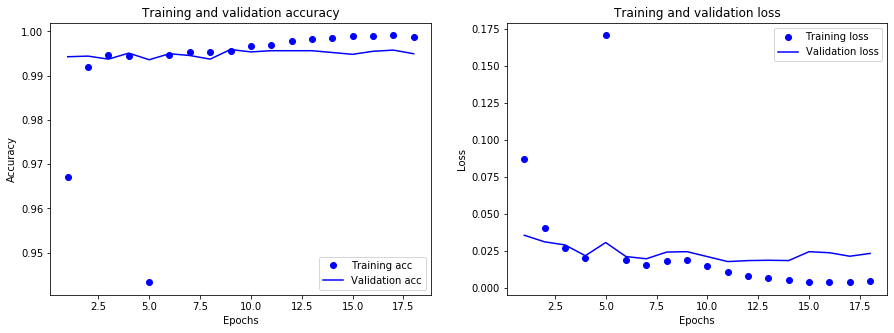

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

f = plt.figure(figsize=(15,5))

ax1 = f.add_subplot(121)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.legend()
ax1.title.set_text('Training and validation accuracy')

ax2 = f.add_subplot(122)
ax2.title.set_text('Generated Synthetic Graph')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.legend()
ax2.title.set_text('Training and validation loss')

plt.show()

### Evaluate Full classifier model

In [26]:
# Extract true labels
ytest_true = np.argmax(y_test, axis=1)

In [27]:
accr = model.evaluate(X_test, y_test, batch_size=512)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

2447/2447 [==============================] - 1s 410us/step
Test set
  Loss: 0.2585
  Accuracy: 0.9489


In [28]:
y_pred = model.predict_classes(X_test, batch_size=512, verbose=1)

2447/2447 [==============================] - 1s 524us/step


In [29]:
y_predscr = model.predict(X_test, batch_size=512, verbose=1)

predpos = np.count_nonzero(y_predscr[:,1] > 0.5)
pred_allpos = predpos / len(y_predscr)
print('Percentage of Positives: {:0.4f}'.format(pred_allpos))

2447/2447 [==============================] - 1s 408us/step
Percentage of Positives: 0.5149


In [30]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

tn, fp, fn, tp = confusion_matrix(ytest_true, y_pred).ravel()
print(tn, fp, fn, tp)
fpr = fp / (fp+tn)
fpr

Accuracy: 0.9489170412750306
Recall: 0.9121915820029027
Precision: 0.9968279143536876
F1 score: 0.9526335733232285

 clasification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94      1069
           1       1.00      0.91      0.95      1378

    accuracy                           0.95      2447
   macro avg       0.95      0.95      0.95      2447
weighted avg       0.95      0.95      0.95      2447


 confusion matrix:
 [[1065    4]
 [ 121 1257]]
1065 4 121 1257


0.0037418147801683817

## Iterative classifier training

In [45]:
# add PGT labels for evaluation
df_normal['Attack'] = 0
df_attacksmall['Attack'] = 1
# print("df_attacksmall value counts: \n", (df_attacksmall['Attack']).value_counts())

# Join and shuffle train attack and normal data
df_train = df_normal.append(df_attacksmall).sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
# df_train =df_normal # df_attacksmall #
print("size of df_train: ", len(df_train))
print("df_train value counts: \n", (df_train['Attack']).value_counts())

size of df_train:  18365
df_train value counts: 
 0    10054
1     8311
Name: Attack, dtype: int64


/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
X_train, y_train = prep_modelinputs(df_train, max_len, tokenizer)
print(X_train.shape, y_train.shape)

(18365, 202) (18365, 2)


In [48]:
iter_model = Sequential()
iter_model.add(Embedding(vocab_size[0] + 1, input_emb_dim, input_length=X_train.shape[1]))
iter_model.add(LSTM(lstm_emb_dim, return_sequences=True)) # dropout=0.2, recurrent_dropout=0.2))
iter_model.add(LSTM(lstm_emb_dim))
# model.add(TimeDistributed(Dense(2, activation='sigmoid')))
iter_model.add(Dense(2, activation='sigmoid'))
iter_model.compile(optimizer=optimizers.adam(lr=0.005), 
              loss='binary_crossentropy', metrics=['acc']) #lr=0.005 config['MODELPARAMS']['LEARNING_RATE_P']

print(iter_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 202, 512)          388096    
_________________________________________________________________
lstm_5 (LSTM)                (None, 202, 300)          975600    
_________________________________________________________________
lstm_6 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 602       
Total params: 2,085,498
Trainable params: 2,085,498
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
X_train, y_train = prep_modelinputs(df_train, max_len, tokenizer)
keep_thres = 0.4 # must be <=0.5

for _ in range(5):
    iter_model.fit(X_train, y_train, epochs=1, 
                      batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], validation_split=0.2, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=7, 
                                               mode='auto', min_delta=0.0002)]) #

    y_predscr = iter_model.predict(X_train, batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], verbose=1)
    
    # Sorting y_predscr and X_train
    sorting = np.argsort(-1*y_predscr[:, 1]) # add (-1*) to argsort the second column in descending order 
    ypred_sorted = y_predscr[sorting] 
    Xtrain_sorted = X_train[sorting]
    
    # reduce Xtrain_sorted and ypred_sorted to keep_num size
    keep_num = int(len(y_predscr)*keep_thres)
    Xtrain_atk = Xtrain_sorted[:keep_num,:]
    ytrain_atk = np.vstack((np.zeros(keep_num), np.ones(keep_num))).T #.shape
    
    # randomly choose from X_norm to create new training set
    Xtrain_norm = X_norm[np.random.choice(X_norm.shape[0], size=keep_num, replace=False), :]
    X_train = np.concatenate((Xtrain_atk,Xtrain_norm), axis=0)
    y_train = np.concatenate((ytrain_atk,y_norm[:len(Xtrain_norm)]), axis=0)
    
    # Shuffle new training set
    shuffler = np.random.permutation(len(X_train))
    X_train = X_train[shuffler]
    y_train = y_train[shuffler]

Train on 14692 samples, validate on 3673 samples
Epoch 1/1
18365/18365 [==============================] - 13s 718us/step
Train on 11753 samples, validate on 2939 samples
Epoch 1/1
14692/14692 [==============================] - 11s 715us/step
Train on 9401 samples, validate on 2351 samples
Epoch 1/1
11752/11752 [==============================] - 8s 692us/step
Train on 7520 samples, validate on 1880 samples
Epoch 1/1
9400/9400 [==============================] - 7s 700us/step
Train on 6016 samples, validate on 1504 samples
Epoch 1/1
7520/7520 [==============================] - 5s 706us/step


### Evaluate Iterative classifier model

In [50]:
# Extract true labels
ytest_true = np.argmax(y_test, axis=1)

In [51]:
accr = iter_model.evaluate(X_test, y_test, batch_size=512)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

2447/2447 [==============================] - 1s 410us/step
Test set
  Loss: 0.1607
  Accuracy: 0.9720


In [52]:
y_pred = iter_model.predict_classes(X_test, batch_size=512, verbose=1)

2447/2447 [==============================] - 1s 412us/step


In [53]:
y_predscr = iter_model.predict(X_test, batch_size=512, verbose=1)

predpos = np.count_nonzero(y_predscr[:,1] > 0.5)
pred_allpos = predpos / len(y_predscr)
print('Percentage of Positives: {:0.4f}'.format(pred_allpos))

2447/2447 [==============================] - 1s 417us/step
Percentage of Positives: 0.5398


In [54]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

tn, fp, fn, tp = confusion_matrix(ytest_true, y_pred).ravel()
print(tn, fp, fn, tp)
fpr = fp / (fp+tn)
fpr

Accuracy: 0.9713935431140172
Recall: 0.9542815674891146
Precision: 0.9947049924357034
F1 score: 0.974074074074074

 clasification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      1069
           1       0.99      0.95      0.97      1378

    accuracy                           0.97      2447
   macro avg       0.97      0.97      0.97      2447
weighted avg       0.97      0.97      0.97      2447


 confusion matrix:
 [[1062    7]
 [  63 1315]]
1062 7 63 1315


0.006548175865294668

In [55]:
fp_classifier = []    
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for percent in percentages:
    tau_threshold = percent
    ytau_pred = (y_predscr[:,0] < tau_threshold).astype(int)
    tn_tmp, fp_tmp, fn_tmp, tp_tmp = confusion_matrix(ytest_true, ytau_pred).ravel()
    tn_tmp, fp_tmp, fn_tmp, tp_tmp 
    fpr_tmp = fp_tmp / (fp_tmp+tn_tmp)
    fp_classifier.append(fpr_tmp)
    
fp_classifier.insert(0,0)
fp_classifier

[0,
 0.005612722170252572,
 0.006548175865294668,
 0.006548175865294668,
 0.006548175865294668,
 0.006548175865294668,
 0.006548175865294668,
 0.006548175865294668,
 0.006548175865294668,
 0.006548175865294668,
 1.0]

2447


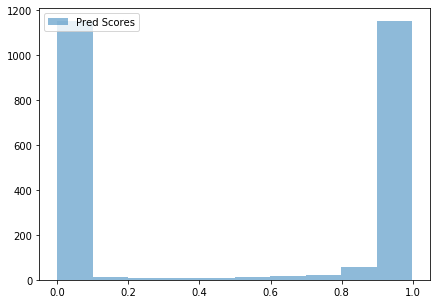

In [40]:
import matplotlib.pyplot as plt

scores = y_predscr[:,1] # classifier atk scores
# def showscore(scores):
fig = plt.figure(figsize=(7,5))
print(len(scores))
plt.hist(scores, bins = 10, alpha=0.5, label='Pred Scores') 
#     plt.hist(scoretype[scores][scoretype['Attack'] == 1], bins = 10, alpha=0.5, label='attacker')
plt.legend(loc='upper left')
plt.show()
    
# showscore(y_predscr) # P scores